In [1]:
#Karen Elizabeth Galindo Schembri, ENOAN 2022
#importamos las librerías necesarias
import math
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor

from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

# Algoritmo de Shor
En este notebook se implementará el algoritmo de Shor para obtener los factores primos de números pequeños (el ejemplo se realizará con el 15). Aunque la teoría nos dice que necesitaremos un primer registro de $n=\lfloor{log_2(N^2)}\rfloor+1$ qubits y otro registro de $m=\lfloor{log_2(N-1)}\rfloor+1$ qubits para poder implementar el algoritmo, aquí se mostrará una versión optimizada que permite utilizar simplemente un $T= 2^t$ tal que $N^2\leq T \leq 2N^2$ y elegir un primer registro de t qubits y un segundo registro de $n=log_2(N)$ qubits, tomada del artículo $Realization$ $of$ $a$ $scalable$ $Shor$ $algorithm$ de los autores Monz, T. y colaboradores.


En la siguiente figura se muestran 4 circuitos con las diferentes maneras de implementar el algoritmo de Shor. $A$ muestra el enfoque propuesto por Kitaev, $B$ muestra un circuito para cualquier base $a$, $C$ muestra la manera actual de implementar el circuito optimizado usando de base $11$, y $D$ muestra la aproximación de Kitaev para las bases $a=2,7,8,13$. Finalmente $E$ muestra diagramas modulares para las operaciones de la forma $a(modN)$ para $a=2,7,8,11,13$. 
En particular nosotros utilizaremos $C$, $D$ y $E$

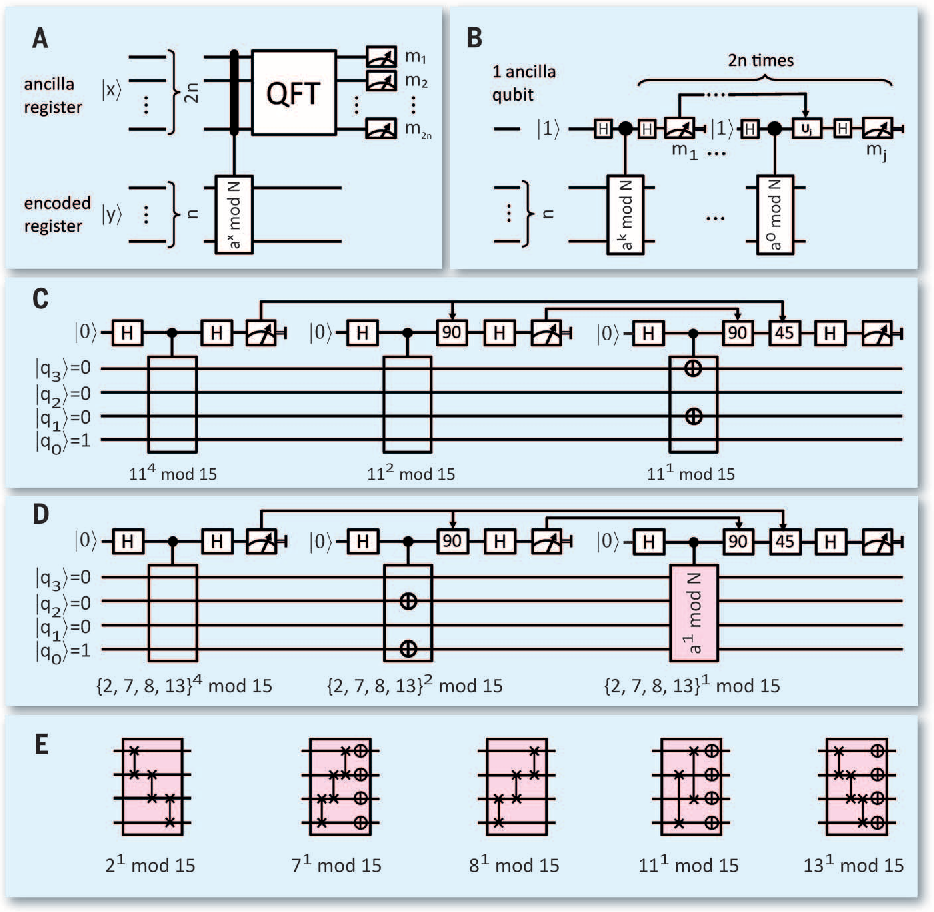

In [2]:
from IPython.display import Image
Image("shoralgorithm.png")

In [3]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11, 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11:
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [4]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11, 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Inicializamos el qubit q[0] en |1> 
    qc.x(qr[0])

    # Aplicamos a**4 mod 15
    qc.h(qr[4])
    #Aplicamos dos Hadamard a los 4 qubits restantes, equivale a la identidad (ie. no hacemos nada)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[0])
    #   reinicializamos los qubits q[4] en |0>
    qc.reset(qr[4])

    # Aplicamos a**2 mod 15
    qc.h(qr[4])
    # Aplicamos una control x
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #Aplicamos rotación
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[1])
    #   reinicializamos los qubits q[4] en |0>
    qc.reset(qr[4])

    # Aplicamos a mod 15
    qc.h(qr[4])
    #   Aplicamos rotaciones, i.e. QFT
    circuit_amod15(qc,qr,cr,a)
    
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[2])

In [5]:
def circuit_11period15(qc,qr,cr):
    # Inicializamos el qubit q[0] en |1> 
    qc.x(qr[0])

    # Aplicamos a**4 mod 15
    qc.h(qr[4])
    #   No hacemos nada (2 Hadamard)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[0])
    #   reinicializamos los qubits q[4] en |0>
    qc.reset(qr[4])

    # Aplicamos a**2 mod 15
    qc.h(qr[4])
    
    qc.p(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[1])
    #   reinicializamos los qubits q[4] en |0>
    qc.reset(qr[4])

    # Aplicamos 11 mod 15
    qc.h(qr[4])
    #   Aplicamos una control x
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    # Aplicamos rotaciones i.e. QFT
    qc.p(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.p(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.p(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   medimos
    qc.measure(qr[4],cr[2])

Probemos nuestro algoritmo para $N=15$, suponiendo que elegimos un $a=7$:

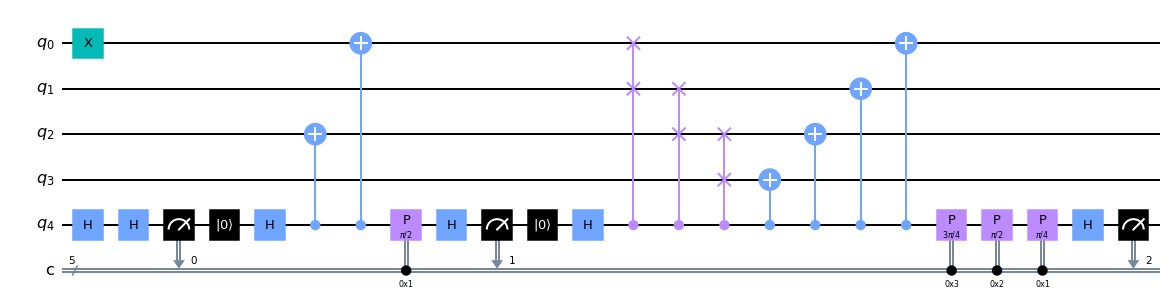

In [6]:
q = QuantumRegister(5, 'q')#Hacemos nuestro registro con 5 qubits
c = ClassicalRegister(5, 'c') #Utilizamos un registro para transportar info. (5 bits clásicos)

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl') #Imprimimos el circuito

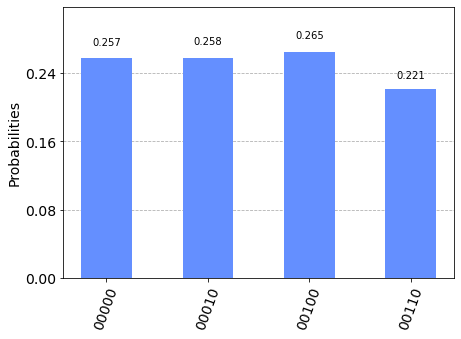

In [7]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

Notamos que obtenemos valores para $y$ con probabilidades bastante similares para los estados $00000$, $00010$, $00100$ y $00110$, los cuales en representación binaria corresponden al $0$, $2$, $4$ y $6$ respectivamente. Recordando que en esta versión optimizada $n=log_2(N)$, debemos aproximar $\frac{y}{2^3}$ por el método de fracciones continuas. De esta forma notamos que los valores $y=2$ y $y=6$ devuelven un periodo $r=4$ que no satisface la condición $a^{r/2}\equiv -1(modN)$. 
Podemos continuar con el siguiente paso y encontrar el máximo común divisor entre $a^{r/2}\pm 1$ y $N$. Entonces, sabiendo que $a=7$ y $N=15$:
\begin{equation}
    p = (a^{r/2}+1,15) = (a^{4/2}+1,15) = (7^2+1,15) = 5
\end{equation}
y
\begin{equation}
    q = (a^{r/2})-1,15) = (a^{4/2}-1,15) = (7^2-1,15) = 3.
\end{equation}

Así, comprobamos que los factores primos de $15$ son $3$ y $5$, utilizando computación cuántica.

# Uso de Qiskit
También podemos implementar la versión del Algoritmo de Shor que incluye Qiskit, y comprobar el resultado anterior. Puedes intentarlo para otros valores de $N$ (no uses un valor muy grande!!).

In [8]:
N = 15
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
shor2 = Shor(quantum_instance=quantum_instance)
result = shor2.factor(N)
print(f"Los factores primos de {N} dados por el Algoritmo de Shor son {result.factors[0]}.")

Los factores primos de 15 dados por el Algoritmo de Shor son [3, 5].
